# Vincent Purcell
##### Data Mining 2 - Summer 2021 #####
##### HW3 - Kaggle Digit Recognizer #####
Some code take from: https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial
Some code also taken from Professor Breitzman's code

Modified CNN multiple times to increase accuracy as much as a could


In [85]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns
import matplotlib.pyplot as plt

In [86]:
train = pd.read_csv("train.csv")
train.head()
test = pd.read_csv("test.csv")

### Get X and Y training data ###

In [87]:
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 
X_train = X_train / 255.0
test = test / 255.0

### Reshape data for keras and get train test split ###

In [89]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.08, random_state=20)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [90]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

n_classes = 10
print("Shape before one-hot encoding: ", Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_val = np_utils.to_categorical(Y_val, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (38640,)
Shape after one-hot encoding:  (38640, 10)


In [91]:
model = Sequential()
model.add(Conv2D(48, kernel_size=(7,7), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters = 36, kernel_size = (7,7),padding = 'valid', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'valid', activation ='relu'))
model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'valid', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation = "softmax"))

In [92]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000005)

epochs = 36
batch_size = 128
#history = model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_test, Y_test))

# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/36
301/301 [==============================] - 72s 234ms/step - loss: 1.1356 - accuracy: 0.6127 - val_loss: 0.1311 - val_accuracy: 0.9613
Epoch 2/36
301/301 [==============================] - 75s 248ms/step - loss: 0.1746 - accuracy: 0.9488 - val_loss: 0.0630 - val_accuracy: 0.9824
Epoch 3/36
301/301 [==============================] - 79s 262ms/step - loss: 0.1078 - accuracy: 0.9694 - val_loss: 0.0405 - val_accuracy: 0.9878
Epoch 4/36
301/301 [==============================] - 73s 244ms/step - loss: 0.0867 - accuracy: 0.9753 - val_loss: 0.0436 - val_accuracy: 0.9899
Epoch 5/36
301/301 [==============================] - 75s 248ms/step - loss: 0.0684 - accuracy: 0.9806 - val_loss: 0.0399 - val_accuracy: 0.9908
Epoch 6/36
301/301 [==============================] - 75s 248ms/step - loss: 0.0660 - accuracy: 0.9808 - val_loss: 0.0467 - val_accuracy: 0.9881
Epoch 7/36
301/301 [==============================] - 73s 242ms/step - loss: 0.0558 - accuracy: 0.9848 - val_loss: 0.0395 - val_ac

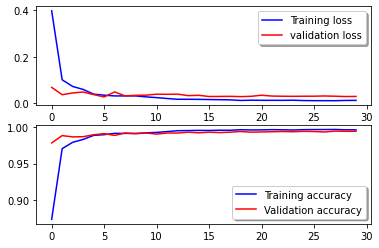

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

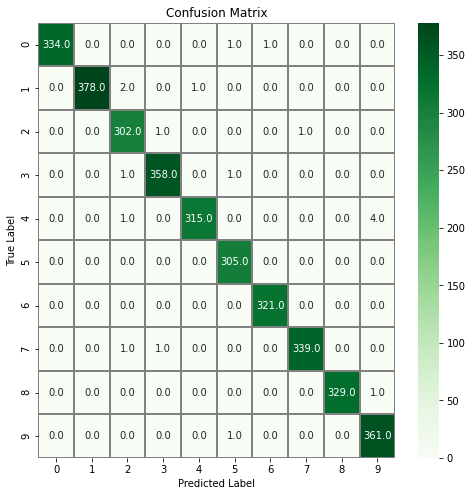

In [ ]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
test_guess_proba = model.predict(test)

In [ ]:
test_predictions = np.argmax(test_guess_proba, axis=1)
results = pd.Series(test_predictions,name="Label")
csv_data = pd.DataFrame({'ImageId' : list(range(1,len(results)+1)),
                         'Label' : results})
csv_data.to_csv('submission.csv', index=False)